# 14대 젠더 관련 의안 분석

### 1992.05.30 ~ 1996.05.29 / 김영삼 정부

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Okt
import logging
import hanja
from krwordrank.hangle import normalize
%matplotlib inline

In [2]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


In [3]:
bill_df = pd.read_csv('/Users/harampark/Documents/research/gender-bill-analysis/data/selenium-data/14대 국회 의안정보.csv', 
                      parse_dates=['제안일자', '의결일자'], index_col=0).reset_index()
bill_df.head()

,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
0,141436,접경지역개발지원에관한특례법안(이한동의원등 6인 외 22인),1996-02-05,의원,1996-05-29,임기만료폐기,제14대 (1992~1996) 제178회,['■ 제안이유民族의 悲劇인 6.25戰爭이후 軍事分界線에 인접한 接境地域은 그 軍事...,통일외무위원회,"['이한동', '김두섭', '박명근', '서정화', '이용삼', '정재철', '박명..."
1,141435,공직선거및선거부정방지법중개정법률안,1996-01-27,위원장,1996-01-27,원안가결,제14대 (1992~1996) 제178회,['■ 제안경위1. 1996年1月26日 權海玉 議員外 3人이 公職選擧 및 選擧不正防...,내무위원회,[]
2,141432,정부조직법중개정법률안(손세일의원등 5인 외 60인),1996-01-16,의원,1996-01-27,폐기,제14대 (1992~1996) 제178회,['■ 제안이유 및 주요골자中小企業의 經營安定과 競爭力을 提高하기 위하여 효율적인 ...,행정위원회,"['손세일', '강철선', '권노갑', '김덕규', '문희상', '김영배', '김영..."
3,141431,정보공개법안(김덕규의원등 5인 외 60인),1996-01-09,의원,1996-05-29,임기만료폐기,제14대 (1992~1996) 제177회,"['■ 제안이유公共機關이 保有하거나 管理하는 情報의 公開를 義務化하고, 國民이 情報...",행정위원회,"['김덕규', '강철선', '권노갑', '문희상', '손세일', '김영배', '김영..."
4,141430,정부조직법중개정법률안,1996-01-09,정부,1996-01-27,원안가결,제14대 (1992~1996) 제178회,['■ 제안이유 및 주요골자체계적이고 효율적인 中小企業支援體制를구축하고 中小企業의 ...,행정위원회,[]


In [4]:
def preprocessing(text): 
    text = text.replace('■ 제안이유', ' ').replace('■ 주요골자', ' ').replace('■ 기타사항', ' ')
    text = text.replace('■ 위원회 수정사항□ 수정이유',' ').replace('■ 제안경위',' ').replace('[',' ').replace(']',' ')
    text = text.replace('녀성', '여성').replace('로동', '노동').replace('륜리','윤리').replace('녀비','여비')
    text = text.replace("'",' ').replace('"',' ').replace('륜락', '윤락')
    return text

def clean_name(text): 
    text = text.split('(')[0]
    return text.strip()

In [5]:
%time bill_df['제안이유'] = bill_df['제안이유'].apply(lambda x: hanja.translate(x, 'substitution'))
%time bill_df['제안이유'] = bill_df['제안이유'].apply(preprocessing)
%time bill_df['의안명'] = bill_df['의안명'].apply(clean_name)

CPU times: user 3.23 s, sys: 24.5 ms, total: 3.25 s
Wall time: 3.28 s
CPU times: user 11.9 ms, sys: 424 µs, total: 12.3 ms
Wall time: 12.5 ms
CPU times: user 1.35 ms, sys: 53 µs, total: 1.4 ms
Wall time: 1.38 ms


In [6]:
bill_df.head(1)

,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
0,141436,접경지역개발지원에관한특례법안,1996-02-05,의원,1996-05-29,임기만료폐기,제14대 (1992~1996) 제178회,민족의 비극인 6.25전쟁이후 군사분계선에 인접한 접경지역은 그 군사적 요인과...,통일외무위원회,"['이한동', '김두섭', '박명근', '서정화', '이용삼', '정재철', '박명..."


## 젠더 관련 의안만 추리기

In [7]:
# 딱히 특정할만한 소관위원회는 없음 
bill_df['소관위원회'].unique()

array(['통일외무위원회', '내무위원회', '행정위원회', '법제사법위원회', '보건복지위원회', '문화체육공보위원회',
       '국회운영위원회', '국제경기대회지원특별위원회', '통상산업위원회', '교육위원회', '건설교통위원회',
       '환경노동위원회', '국방위원회', '농림수산위원회', '재정경제위원회', '통신과학기술위원회', '지방자치특별위원회',
       '보건사회위원회', '외무통일위원회', '행정경제위원회', '건설위원회', '상공자원위원회', '교통위원회',
       '노동환경위원회', '체신과학기술위원회', '재무위원회', '정치관계법심의특별위원회', '노동위원회',
       '경제과학위원회', '교통체신위원회', '대전세계박람회지원특별위원회', '특위', '상공위원회',
       '교육체육청소년위원회'], dtype=object)

In [8]:
keyword = r'.*(여성|성범죄|남녀|호주|보육|육아|가부장|강간|간통죄|정조|모성|윤락|성폭력|양성평등|\
                양성 평등|성접대|위안부|정신대|남녀평등|성차별|모성|성희롱|낙태|부녀자|가족|가정폭력|모자보건).*'
gender = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
gender = gender.reset_index()
gender = gender.drop('index',1)
gender.shape

(81, 10)

In [9]:
for ind in range(len(gender)): 
    print(gender.loc[ind,'의안번호'])
    print(gender.loc[ind, '제안이유'])

141436
   민족의 비극인 6.25전쟁이후 군사분계선에 인접한 접경지역은 그 군사적 요인과 자연환경으로 인하여 군사시설보호법, 자연공원법등 여러 법령에 의한 각종 규제로 발전이 현저히 둔화되어 다른 지역에 비하여 상대적으로락후되어 있는 실정임.접경지역은 경제가 황폐할 뿐만 아니라 교육·문화·의료 등의 문화·복지분야에서도 다른 지역에 비해 소외되어 주민들의 생활이 극히 불편하며, 특히 전방지역으로서 군사시설물이 많이 설치되어 있고 군인과 그 가족들이 많이 거주하고 있음에도 군주둔에 따른 주민지원은 거의 없어 지역주민의 이탈이 계속되고 있음.국토의 균형개발과 통일을 위한 지역기반의 조성 및 남북교류의 거점 확보, 그리고 지역주민의 생활향상을 위하여 접경지역의 개발을 특별지원하려는 것임. 1. 군사분계선에 인접하는 시·군을“접경지역”으로 정의하고, 접경지역의 개발을 촉진함으로써 국토의 균형있는 발전과 주민의 생활향상에 이바지하며, 통일을 위한 거점을 확보함을 이 법의 목적으로 함(안 제1조,제2조제1호)2. 통일원장관은 국무회의의 심의를 거쳐 접경지역중 남북교류를활성화하고 통일의 거점에 적합한 지역을 평화시로 지정할 수 있도록 함(안 제4조)3. 접경지역의 도지사는 교통시설·산업기반시설·문화복지시설의 확충 등을 내용으로 하는 개발계획을 수립하도록 하고, 대통령의 승인을 얻어 공고하도록 함(안 제5조, 제6조)4. 개발사업을 시행하고자 하는 자는 도지사의 승인을 얻도록 하고, 도지사는 농어민단체에 대하여 우선적으로 사업의 승인을 하도록 함(안 제8조)5. 접경지역의 개발사업에 대하여는 환경영향평가법의 특례를 인정하여 도지사가 환경영향평가협의를 하도록하고, 또한 산림법의 특례를 두어 보전림지의 전용허가를 받은 자에 대하여 국유림을 대부·사용허가할 수있도록 함(안 제9조, 제10조)6. 접경지역에는 관광진흥법에 의한 허가요건을 완화하여 카지노업의 허가를 할 수 있도록 하되, 이익金 중일부를 접경지역과 관련된 관광진흥 및 지역개발을 위하여 사용하도록 함(안 제11조)

In [10]:
remove_bill = [141436, 141422, 141420, 141389, 141374, 141373, 141372, 141358, 141356, 141340, 141338,
               141318, 141308, 141301, 141300, 141294, 141274, 141228, 141213, 141161, 141072, 140991, 
               140983, 140977, 140971, 140964, 140960, 140942, 140900, 140896, 140889, 140888, 140840, 
               140827, 140799, 140784, 140783, 140759, 140751, 140668, 140540, 140539, 140527, 140516, 
               140502, 140482, 140472, 140344, 140259, 140244, 140224, 140198, 140145, 140138, 140121, 
               140090, 140089, 140088, 140040]
gender = gender[~gender['의안번호'].isin(remove_bill)]
gender = gender.reset_index()
gender = gender.drop('index',1)
gender.shape

(22, 10)

In [11]:
len(remove_bill)

59

In [12]:
gender

,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
0,141424,여성발전기본법안,1995-12-19,위원장,1995-12-19,원안가결,제14대 (1992~1996) 제177회,1. 여성발전기본법안은 주良자의원외 22인으로부터 1995년 12월 6일 발의...,행정위원회,[]
1,141410,남녀평등기본법안,1995-12-09,의원,1995-12-19,대안반영폐기,제14대 (1992~1996) 제177회,개인의 존엄과 남녀의 평등을 기초로 모든 영역에서 성에 대한 정형화를 소멸시키...,행정위원회,"['손세일', '강철선', '권노갑', '김덕규', '문희상', '이우정', '조세..."
2,141407,여성발전기본법안,1995-12-06,의원,1995-12-19,대안반영폐기,제14대 (1992~1996) 제177회,성차별적 관행이 뿌리깊은 우리 현실에서 헌법의 기본리념에 따라 사회 각 분야에...,행정위원회,"['주양자', '강선영', '정옥순', '김해석', '김형오', '류흥수', '박명..."
3,141388,형법중개정법률안,1995-12-01,위원장,1995-12-02,원안가결,제14대 (1992~1996) 제177회,1. 정부에서는 1985년 6월 형사법개정특별심의위원회를 구성·발족한 이후 1...,법제사법위원회,[]
4,141332,남녀고용평등법중개정법률안,1995-11-10,의원,1996-05-29,임기만료폐기,제14대 (1992~1996) 제177회,근로자의 고용 및 제반근무환경에 있어서의 남녀평등을 확보하기 위하여 성별 등을...,환경노동위원회,"['이우정', '강부자', '김말룡', '김해석', '박세직', '신계륜', '원혜..."
5,141166,소득세법중개정법률안,1995-09-30,정부,1995-12-02,수정가결,제14대 (1992~1996) 제177회,"金융소득종합과세의 실효성을 높이기 위하여 채권등의 과세방식을 보완하고, 5년이...",재정경제위원회,[]
6,141048,영유아보육법중개정법률안,1995-03-02,의원,1996-05-29,임기만료폐기,제14대 (1992~1996) 제172회,현행 영유아보육법의 미비점을 보완하여 보육대상을 모든 영유아로 확대하고 영유아...,보건복지위원회,"['김원웅', '강창성', '강철선', '강희찬', '국종남', '권노갑', '김덕..."
7,141036,국회법중개정법률안,1995-02-27,위원장,1995-02-27,원안가결,제14대 (1992~1996) 제172회,1995년 2월 27일 국회운영위원회의 권해옥·李 협·허재홍·박주천·최두환위원...,국회운영위원회,[]
8,140950,남녀고용평등법중개정법률안,1994-11-28,의원,1995-07-15,수정가결,제14대 (1992~1996) 제170회,"현행 남녀고용평등법의 규정 중 남녀차별금지규정 및 육아휴직제도를 보완하고, 직...",환경노동위원회,"['주양자', '정옥순', '최상용', '권해옥', '김기도', '김동권', '김영..."
9,140884,국가공무원법중개정법률안,1994-11-07,정부,1994-12-02,원안가결,제14대 (1992~1996) 제170회,"공직사회에 일하는 분위기를 조성하기 위하여 사무관승진시험제도를 개선하고, 근무...",행정경제위원회,[]


In [12]:
gender.to_csv('14th-gender-bill.csv',encoding='utf-8-sig')

## wordcloud 시각화

In [13]:
# 한글 전처리
def preprocessing(text): 
    text_pre1 = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text_pre2 = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text_pre1)
    return str(text_pre2)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','일명',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
              '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등',\
              '안','바','이','것','부터','수','시','자']

    text = [word for word in text if word not in stopwords]
    return text

In [14]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

In [15]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

CPU times: user 6.9 ms, sys: 1.22 ms, total: 8.11 ms
Wall time: 10.1 ms


In [16]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [17]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 15.8 s, sys: 458 ms, total: 16.3 s
Wall time: 8.2 s


0    [여성발전기본법안, 여성발전기본법안, 자의원외, 발의, 동년, 당위원회에회부되, 남...
1    [남녀평등기본법안, 개인, 존엄, 남녀, 평등, 기초, 영역, 정형화, 소멸, 개인...
2    [여성발전기본법안, 성차별적, 관행, 우리, 현실, 헌법, 기본리념, 사회, 분야,...
Name: tokens, dtype: object

In [18]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)

CPU times: user 32 ms, sys: 629 µs, total: 32.6 ms
Wall time: 21.7 ms


In [19]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [20]:
model = Word2Vec(gender['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=0)

2020-09-27 00:10:48,966 : INFO : collecting all words and their counts
2020-09-27 00:10:48,969 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-27 00:10:48,979 : INFO : collected 1900 word types from a corpus of 4344 raw words and 22 sentences
2020-09-27 00:10:48,981 : INFO : Loading a fresh vocabulary
2020-09-27 00:10:48,989 : INFO : effective_min_count=10 retains 49 unique words (2% of original 1900, drops 1851)
2020-09-27 00:10:48,991 : INFO : effective_min_count=10 leaves 1018 word corpus (23% of original 4344, drops 3326)
2020-09-27 00:10:48,999 : INFO : deleting the raw counts dictionary of 1900 items
2020-09-27 00:10:49,002 : INFO : sample=0.001 downsamples 49 most-common words
2020-09-27 00:10:49,015 : INFO : downsampling leaves estimated 263 word corpus (25.9% of prior 1018)
2020-09-27 00:10:49,017 : INFO : estimated required memory for 49 words and 100 dimensions: 63700 bytes
2020-09-27 00:10:49,029 : INFO : resetting layer weights
2020-09-27

2020-09-27 00:10:49,345 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:10:49,346 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:10:49,348 : INFO : EPOCH - 15 : training on 4344 raw words (267 effective words) took 0.0s, 27557 effective words/s
2020-09-27 00:10:49,358 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:10:49,362 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:10:49,366 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:10:49,368 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:10:49,376 : INFO : EPOCH - 16 : training on 4344 raw words (265 effective words) took 0.0s, 15014 effective words/s
2020-09-27 00:10:49,400 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:10:49,402 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 0

2020-09-27 00:10:49,653 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:10:49,655 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:10:49,656 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:10:49,658 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:10:49,660 : INFO : EPOCH - 32 : training on 4344 raw words (293 effective words) took 0.0s, 42671 effective words/s
2020-09-27 00:10:49,663 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:10:49,665 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:10:49,666 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:10:49,667 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:10:49,669 : INFO : EPOCH - 33 : training on 4344 raw words (279 effective words) took 0.0s, 39234 effective words/s
2020-09-27 0

2020-09-27 00:10:50,032 : INFO : EPOCH - 48 : training on 4344 raw words (249 effective words) took 0.0s, 6582 effective words/s
2020-09-27 00:10:50,036 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:10:50,038 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:10:50,039 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:10:50,040 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:10:50,042 : INFO : EPOCH - 49 : training on 4344 raw words (272 effective words) took 0.0s, 45998 effective words/s
2020-09-27 00:10:50,049 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:10:50,051 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:10:50,052 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:10:50,054 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00

2020-09-27 00:10:50,262 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:10:50,263 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:10:50,265 : INFO : EPOCH - 65 : training on 4344 raw words (285 effective words) took 0.0s, 36777 effective words/s
2020-09-27 00:10:50,270 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:10:50,272 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:10:50,274 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:10:50,276 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:10:50,278 : INFO : EPOCH - 66 : training on 4344 raw words (249 effective words) took 0.0s, 32174 effective words/s
2020-09-27 00:10:50,281 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:10:50,283 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 0

2020-09-27 00:10:50,534 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:10:50,536 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:10:50,538 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:10:50,539 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:10:50,540 : INFO : EPOCH - 82 : training on 4344 raw words (254 effective words) took 0.0s, 32145 effective words/s
2020-09-27 00:10:50,545 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:10:50,546 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:10:50,548 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:10:50,550 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:10:50,552 : INFO : EPOCH - 83 : training on 4344 raw words (255 effective words) took 0.0s, 31540 effective words/s
2020-09-27 0

2020-09-27 00:10:50,801 : INFO : EPOCH - 98 : training on 4344 raw words (276 effective words) took 0.0s, 35189 effective words/s
2020-09-27 00:10:50,810 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:10:50,812 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:10:50,815 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:10:50,820 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:10:50,825 : INFO : EPOCH - 99 : training on 4344 raw words (282 effective words) took 0.0s, 19125 effective words/s
2020-09-27 00:10:50,832 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:10:50,834 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:10:50,835 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:10:50,836 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 0

In [28]:
print(model.wv.most_similar('여성'))
# print(model.wv.most_similar('청소년'))

[('규정함', 0.9942313432693481), ('지방자치단체', 0.9940261244773865), ('사회', 0.9891446828842163), ('수립', 0.9864594340324402), ('남녀평등', 0.9816813468933105), ('보호', 0.9764187335968018), ('설치', 0.9752936959266663), ('필요', 0.9651862382888794), ('성폭력범죄', 0.9401894807815552), ('피해자', 0.9334778785705566)]


In [22]:
gender['tokens']

0     [여성발전기본법안, 여성발전기본법안, 자의원외, 발의, 동년, 당위원회에회부되, 남...
1     [남녀평등기본법안, 개인, 존엄, 남녀, 평등, 기초, 영역, 정형화, 소멸, 개인...
2     [여성발전기본법안, 성차별적, 관행, 우리, 현실, 헌법, 기본리념, 사회, 분야,...
3     [형법중개정법률, 정부, 형사법개정특별심의위원회, 구성, 발족, 이후, 년여, 기간...
4     [남녀고용평등법중개정법률, 근로자, 고용, 제반근무환경, 남녀평등, 확보, 성별, ...
5     [소득세법중개정법률, 융소득종합과세, 실효성, 채권등, 과세방식, 보완, 장기저축,...
6     [영유아보육법중개정법률, 현행, 영유아보육법, 미비점, 보완, 보육대상, 영유아, ...
7     [국회법중개정법률, 국회운영위원회, 권해옥, 허재홍, 박주천, 최두환위원, 서면동의...
8     [남녀고용평등법중개정법률, 현행, 남녀고용평등법, 규정, 남녀차별금지규정, 육아휴직...
9     [국가공무원법중개정법률, 공직사회, 분위기, 조성, 사무관승진시험제도, 개선, 근무...
10    [소득세법중개정법률, 융실명제, 취지, 공평과세, 실시, 현행, 분리과세, 배당소득...
11    [윤락행위등방지법개정법률안, 윤락행위자, 선도하기, 선도보호시설, 입소, 법적근거,...
12    [교육공무원법중개정법률, 교사, 신규채용, 공개전형, 실시, 채용후, 담당, 직무,...
13    [성폭력범죄의처벌및피해자보호등에관한법률안, 각종, 성폭력범죄, 흉폭화, 집단화, 지...
14    [고용정책기본법안, 산업구조, 고도화, 생산시설, 자동화, 국내외, 경기, 변동등,...
15    [일제하일본군위안부에대한생활안정지원법안, 양국간, 현안과제, 하나, 일제하, 일본군...
16    [소득세법중개정법률, 수준, 자연적, 상승추세, 근로소득공제, 기초공제등, 각종, ...
17    [성폭력행위처벌등에관한법률안, 도시화, 개방화, 물결, 현재, 우리사회, 여

In [23]:
import nltk 
from wordcloud import WordCloud

def total_tokens(df): 
    gender_tokens = []
    for row in df: 
        for word in row: 
            gender_tokens.append(word)
    return gender_tokens

def frewords_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    plt.figure(figsize=(12,6))
    ko.plot(50) # 상위 50 토큰를 정렬하여 보여줌 
    plt.show()
    
def wordcloud_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    data = ko.vocab().most_common(150)
    data2 = dict(data)
    font_path = '/usr/share/fonts/BlackHanSans-Regular.ttf'

    wordcloud = WordCloud(font_path=font_path,
                          width = 800, 
                         height = 800)

    wordcloud = wordcloud.generate_from_frequencies(data2)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [24]:
gender_word = total_tokens(gender['tokens'])

In [29]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','규정함','본회','수립','항제', '의결제','촉진','의결',
            '영역','도모','확대','구현','이외','원안폐','조등','퍼센트','현행','신설']
gender_word = [each_word for each_word in gender_word if each_word not in stopwords]

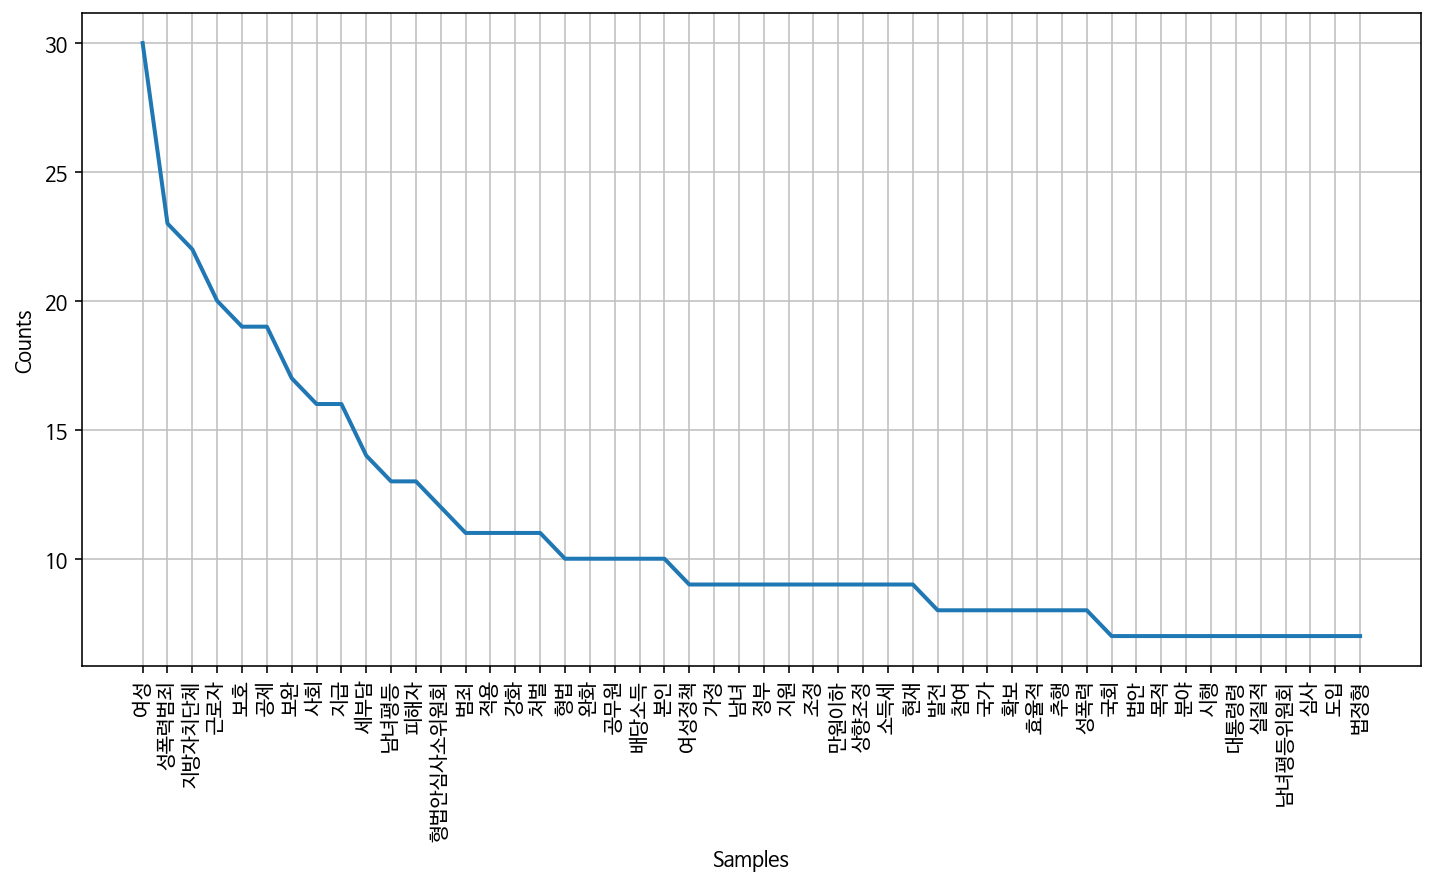

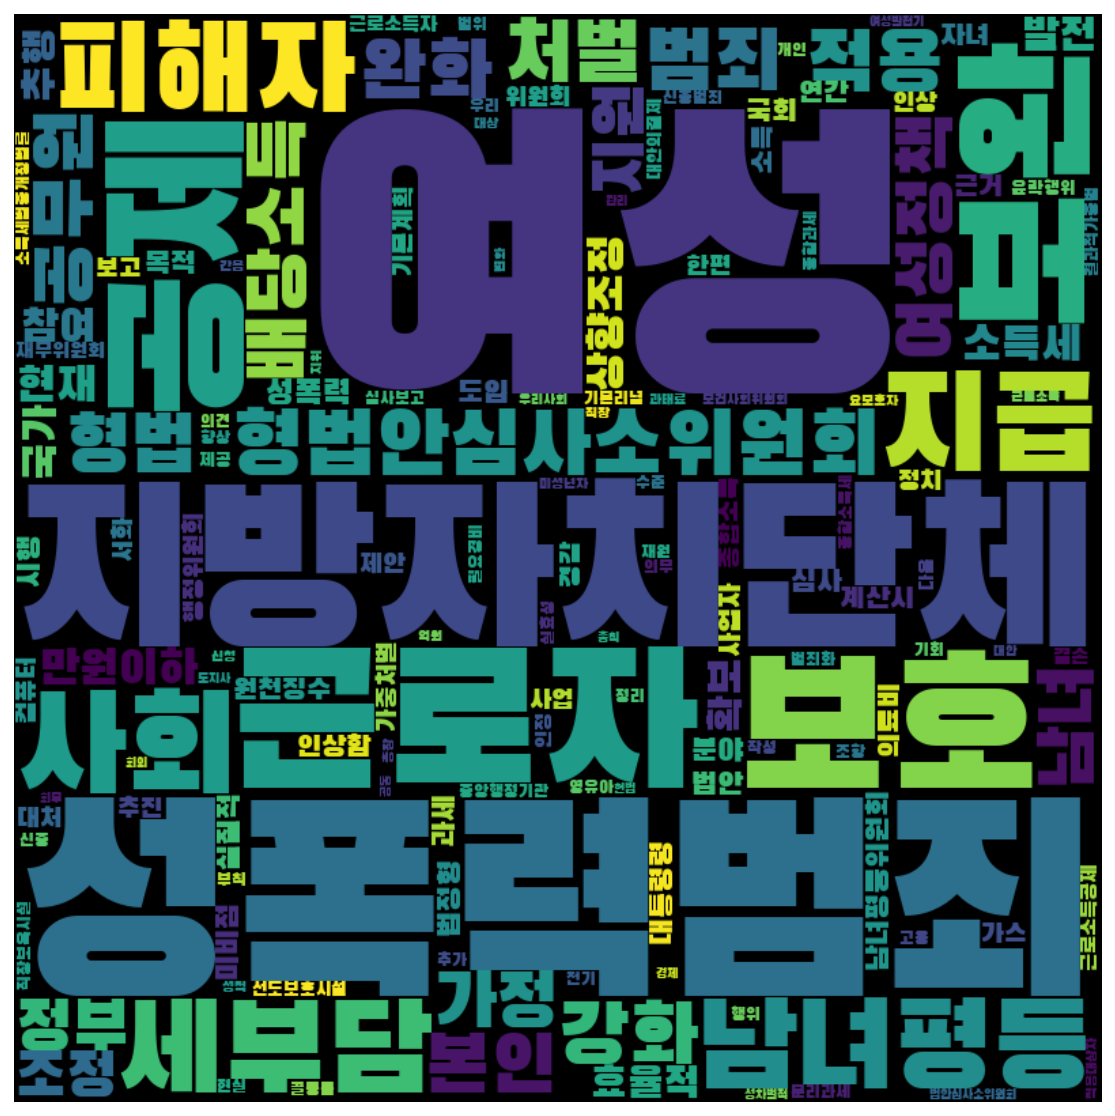

In [30]:
frewords_vis(gender_word)
wordcloud_vis(gender_word)